In [1]:
import pandas as pd
import numpy as np

df_bacteria = pd.read_excel("data/bacteria/avg/d7/0-dmsp.xlsx", header=None)
df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()
time = df_bacteria_time.tolist()
log_bacteria = np.log(np.array(bacteria) + 1e-9)

In [2]:
bacteria

[1000.0,
 224930.13749366478,
 3521259.8050853503,
 4590839.074168486,
 5915542.2121661985,
 8312659.72161613,
 22204214.162020233,
 48493138.9379959,
 79508373.47916377,
 119082533.4472787,
 112967209.47291188,
 160136253.2354889]

In [3]:
def ode(t, y, params):
    muB = params[0]
    return [muB * y[0]]

In [4]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:1] # first 1
        y0 = theta_y0[1:] # last 1

        sol = solve_ivp(
            fun=lambda t, y: ode(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [5]:
import pymc as pm
ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    muB = pm.Uniform('muB', lower=0, upper=1)
    B0 = pm.Uniform('B0', lower=2e4, upper=1e7)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", 1)

    sol = ode_op(pt.stack([muB, B0]))

    pm.Normal("Y_obs", 
              mu=pm.math.log(sol[:, 0] + 1e-9), 
              sigma=sigma_bacteria, 
              observed=log_bacteria)

In [6]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4,
                      return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muB]
>Metropolis: [B0]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 70 seconds.


In [7]:
import matplotlib.pyplot as plt
import arviz as az
az.summary(
    trace,
    round_to=10
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
muB,0.688521,0.150857,0.405121,9.576847e-01,0.004083,0.002402,1388.088636,2591.972477,1.001736
B0,405706.536152,691799.566652,20439.778225,1.238132e+06,18037.600954,49134.873816,1384.290587,2356.702843,1.002297
sigma_bacteria,1.764104,0.355096,1.158699,2.420417e+00,0.006395,0.004207,3360.126600,5045.217553,1.001090


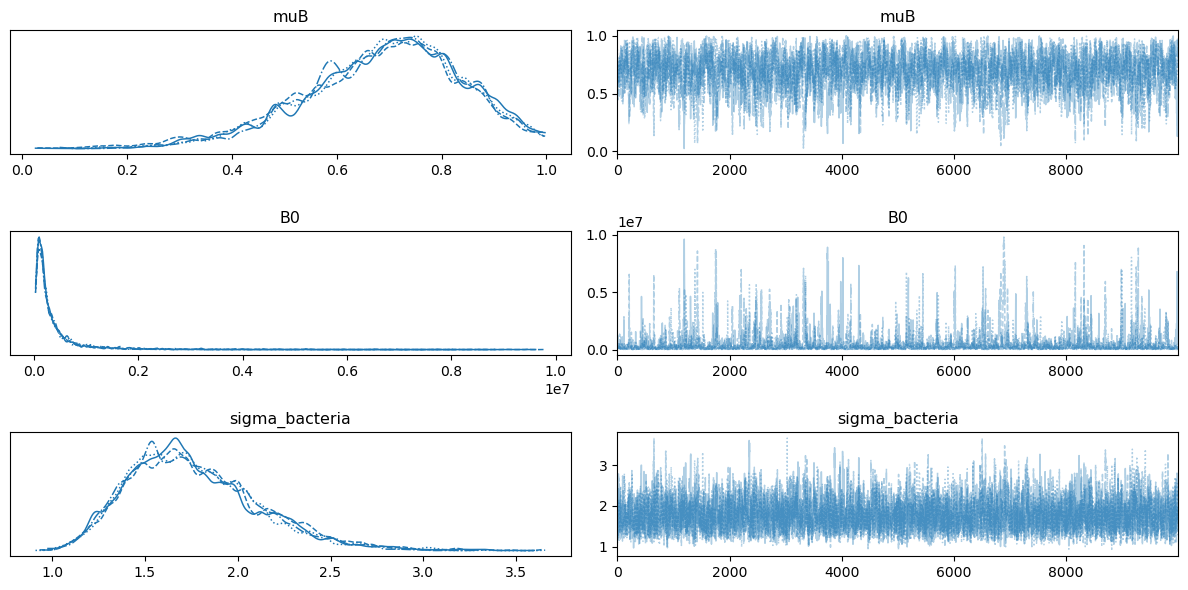

In [8]:
az.plot_trace(trace, 
              backend_kwargs={"tight_layout": True})

plt.show()

In [9]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        #muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        #k0      = float(posterior["k"].values[c, d])
        #phi0    = float(posterior["phi"].values[c, d])
        #beta0  = float(posterior["beta"].values[c, d])

        #H00 = float(posterior["H0"].values[c, d])
        #P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muB0], dtype=float)
        y0 = [B00]
        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims

import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    #host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    #host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [bacteria]
    labels = ["Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


IndexError: list index out of range

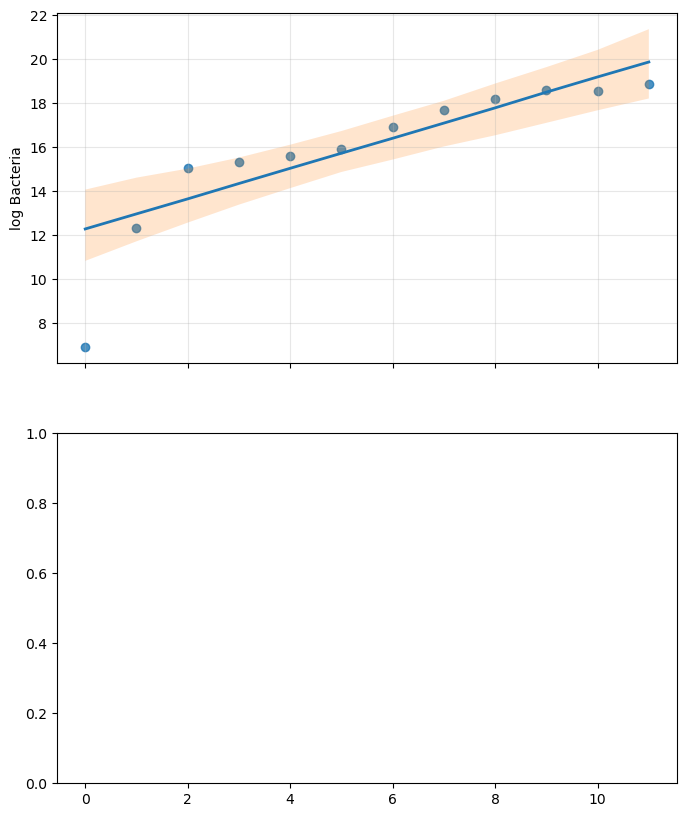

In [10]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    bacteria=bacteria,
    ode_rhs=ode,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
#plt.savefig(save_path + "-posterior-fit.png")
plt.show()